In [0]:
import pandas as pd
import warnings
from matplotlib import pyplot as plt
from copy import deepcopy
warnings.filterwarnings('ignore')

# Trainng Samples loaded from Github Repo
ratings_path = 'https://raw.githubusercontent.com/usef-kh/EC503Project/master/Datasets/ml-1m/ratings.dat'
titles_path = 'https://raw.githubusercontent.com/usef-kh/EC503Project/master/Datasets/ml-1m/movies.dat'

ratings = pd.read_csv(ratings_path, sep  = "::", names = ['UserID', 'MovieID', 'Rating', 'Timestamp'])
titles = pd.read_csv(titles_path, sep = "::", names = ['MovieID', 'Title', 'Genres'], encoding ='latin-1')

In [4]:
data = pd.merge(ratings, titles, on='MovieID')
data.head(10)

stats = pd.DataFrame()

stats['Average Rating'] = data.groupby('Title')['Rating'].mean()
stats['Rating Count'] = data.groupby('Title')['Rating'].count()

stats.head()

,Average Rating,Rating Count
Title,,
"$1,000,000 Duck (1971)",3.027027,37
'Night Mother (1986),3.371429,70
'Til There Was You (1997),2.692308,52
"'burbs, The (1989)",2.910891,303
...And Justice for All (1979),3.713568,199


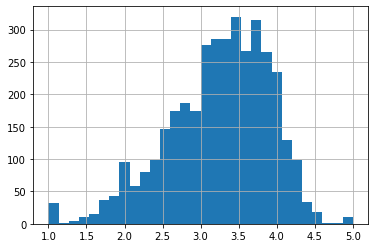

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
stats['Average Rating'].hist(bins=30)

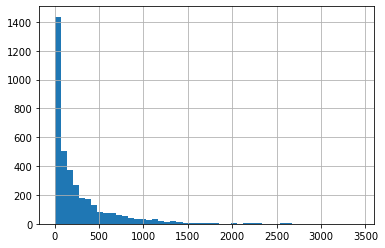

In [6]:
%matplotlib inline
stats['Rating Count'].hist(bins=50)

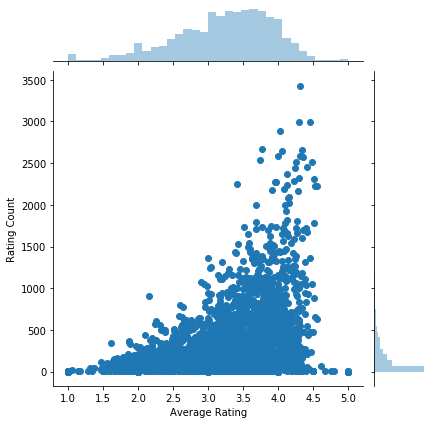

In [7]:
import seaborn as sns
sns.jointplot(x='Average Rating', y='Rating Count', data=stats)

In [8]:
mtrx = data.pivot_table(index='UserID', columns='Title', values='Rating')
# mtrx.fillna(0 ,inplace = True)
mtrx.head()

Title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),"13th Warrior, The (1999)",187 (1997),2 Days in the Valley (1996),20 Dates (1998),"20,000 Leagues Under the Sea (1954)",200 Cigarettes (1999),2001: A Space Odyssey (1968),2010 (1984),24 7: Twenty Four Seven (1997),24-hour Woman (1998),28 Days (2000),3 Ninjas: High Noon On Mega Mountain (1998),3 Strikes (2000),"301, 302 (1995)","39 Steps, The (1935)","400 Blows, The (Les Quatre cents coups) (1959)",42 Up (1998),52 Pick-Up (1986),54 (1998),"7th Voyage of Sinbad, The (1958)",8 1/2 (1963),8 1/2 Women (1999),8 Heads in a Duffel Bag (1997),8 Seconds (1994),8MM (1999),A Chef in Love (1996),Abbott and Costello Meet Frankenstein (1948),"Abominable Snowman, The (1957)",About Adam (2000),About Last Night... (1986),...,Wonderland (1997),Wonderland (1999),Woo (1998),"Wood, The (1999)","Wooden Man's Bride, The (Wu Kui) (1994)",Working Girl (1988),"World Is Not Enough, The (1999)","World of Apu, The (Apur Sansar) (1959)","Wrong Man, The (1956)","Wrong Trousers, The (1993)",Wrongfully Accused (1998),Wyatt Earp (1994),"X-Files: Fight the Future, The (1998)",X-Men (2000),X: The Unknown (1956),Xiu Xiu: The Sent-Down Girl (Tian yu) (1998),Yankee Zulu (1994),"Yards, The (1999)","Year My Voice Broke, The (1987)",Year of Living Dangerously (1982),Year of the Horse (1997),Yellow Submarine (1968),Yojimbo (1961),You Can't Take It With You (1938),You So Crazy (1994),You've Got Mail (1998),Young Doctors in Love (1982),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Young and Innocent (1937),Your Friends and Neighbors (1998),Zachariah (1971),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997),eXistenZ (1999)
UserID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
stats.sort_values('Rating Count', ascending=False).head(10)

,Average Rating,Rating Count
Title,,
American Beauty (1999),4.317386,3428
Star Wars: Episode IV - A New Hope (1977),4.453694,2991
Star Wars: Episode V - The Empire Strikes Back (1980),4.292977,2990
Star Wars: Episode VI - Return of the Jedi (1983),4.022893,2883
Jurassic Park (1993),3.763847,2672
Saving Private Ryan (1998),4.337354,2653
Terminator 2: Judgment Day (1991),4.058513,2649
"Matrix, The (1999)",4.315830,2590
Back to the Future (1985),3.990321,2583


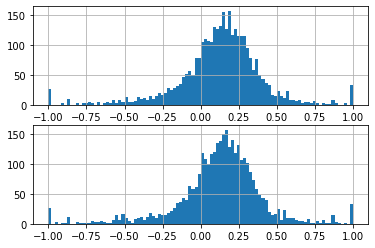

In [20]:
methodlist = ['pearson', 'spearman']
for i,m in enumerate(methodlist):

  AFO_user_rating = mtrx['Air Force One (1997)']
  similar_to_air_force_one=mtrx.corrwith(AFO_user_rating, method = m)

  corr_AFO = pd.DataFrame(similar_to_air_force_one, columns=['correlation'])
  corr_AFO.dropna(inplace=True)
  # corr_AFO.head()

  corr_AFO = corr_AFO.join(stats['Rating Count'],lsuffix='')

  corr_AFO.head()

  corr_AFO[corr_AFO['Rating Count'] > 100].sort_values(by='correlation', ascending=False).head(10)
  corr_AFO.head()

  # %matplotlib inline
  plt.subplot(2,1 ,i+1) 
  corr_AFO['correlation'].hist(bins=100)



In [23]:
def correlate(movie, mtrx, corrtype):
  movie_ratings = mtrx[movie]
  correlations = mtrx.corrwith(movie_ratings, method = corrtype)
  
  correlations_df = pd.DataFrame(correlations, columns=['correlation'])
  correlations_df.dropna(inplace=True)

  correlations_df = correlations_df.join(stats['Rating Count'],lsuffix='')
  correlations_df[correlations_df['Rating Count'] > 100].sort_values(by='correlation', ascending=False)

  return correlations_df

def recommend(mtrx, userid, n):
  '''Return a list of top n recommended movies accoring 
     to the correlation between the useres top rated movies 
     and other movie ratings'''

  user_profile = deepcopy(mtrx.iloc[userid])
  user_profile.fillna(0, inplace = True)
  
  user_profile.sort_values(ascending=False, inplace=True)
  user_preferences = user_profile.index

  possible_movies = deepcopy(mtrx.iloc[userid])
  possible_movies = possible_movies[pd.isnull(possible_movies)]

  top_picks = pd.DataFrame()
  for i in range(n):
    movie = user_preferences[i]
    results = correlate(movie, mtrx, 'spearman')
    results = results.loc[possible_movies.index,:]
    results.sort_values(by=['correlation'], inplace = True, ascending=False)
    results.dropna(inplace = True)
    results = results['correlation']
    top5 = results.iloc[0:n]

    top_picks = pd.concat([top_picks, top5])

  top_picks.columns = ['correlation']

  top_picks.sort_values(by = ['correlation'], inplace = True, ascending=False)

  return top_picks[0:n]


# extract 7 recommendations for the first user
recs = recommend(mtrx, 1, 7)
print(recs)

                                                   correlation
Shopping (1994)                                            1.0
Sticky Fingers of Time, The (1997)                         1.0
Midaq Alley (Callejón de los milagros, El) (1995)          1.0
Journey of August King, The (1995)                         1.0
Head On (1998)                                             1.0
Firelight (1997)                                           1.0
Jail Bait (1954)                                           1.0
